# The emergence of consensus in the Python community

## There should be one-- and preferably only one --obvious way to do it. (Tim Peters)

This is a study about undocumented consensus in the Python community, so you don't have to do it.

## How I did it

I used a script crawling https://pypi.org/rss/updates.xml to get some Python projects, then crawled their github repository (around 4k repositories at the time of writing).

Then I extracted data points from those repositories, also by checking out random commits in their history to not only study the present, but also the past.

## But why?

To answer questions a human or a search engine won't be able to answer, like:

- For my README, should I use restructuredText or Markdown?
- unittest, nose, or pytest?
- ``setup.py`` install_requires, vs ``requirements.txt`` vs ``Pipfile``?
- ...

## Is it biaised?

Yes! I only crawled projects published on pypi AND hosted on github, so I'm hitting a specific population.

In [3]:
from pathlib import Path
from collections import defaultdict
import json
import pandas as pd
from datetime import datetime, timedelta
from pytz import utc
from glob import glob

%matplotlib notebook

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [4]:
raw_data = pd.read_csv('stats.csv', index_col='date', parse_dates=['date'])

## Let's only take 10 years of data

There is not enough datapoints past this, graphs tends to be messy.

In [5]:
stats = raw_data.loc['2008-01-01':,:].resample('6M')

# README files

<IPython.core.display.Javascript object>


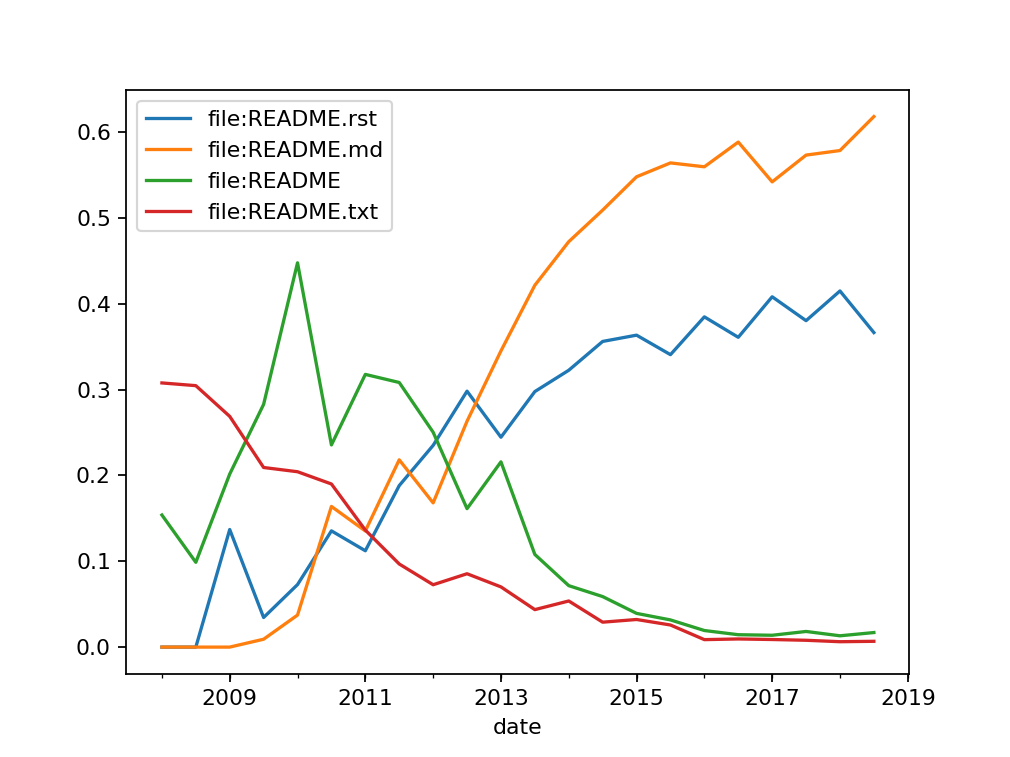

In [4]:
readmes = (stats['file:README.rst', 'file:README.md', 'file:README', 'file:README.txt'].mean().plot())

# README files — concensus

10 years ago, people used ``README`` and ``README.txt``.

It changed around 2011, now we use ``README.md`` and ``README.rst`` files

``Markdown`` won, I bet for its simplicity and readability. 

But pypi don't support markdown I hear? That's False since like march 2018 \o/
see: https://pypi.org/project/markdown-description-example/

So use ``README.md`` files!

# Requirements

<IPython.core.display.Javascript object>


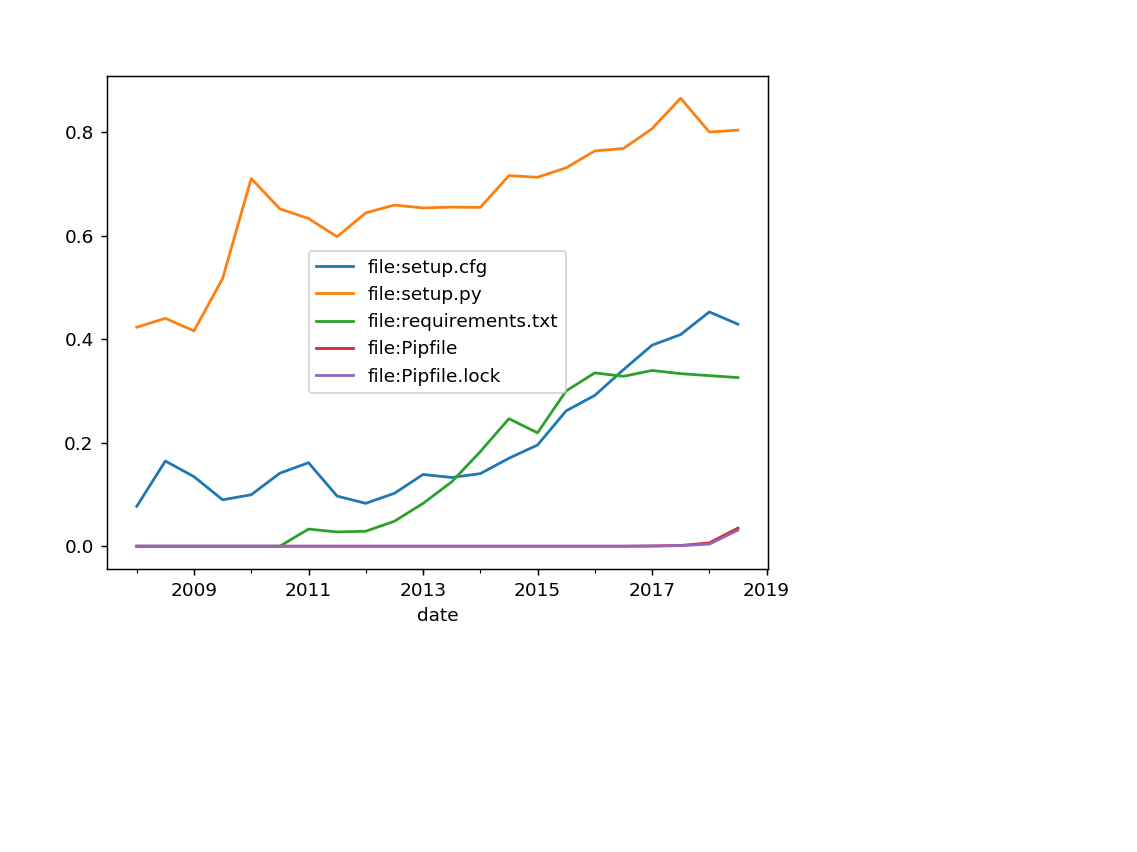

In [8]:
setups = stats['file:setup.cfg', 'file:setup.py', 'file:requirements.txt', 'file:Pipfile', 'file:Pipfile.lock'].mean().plot()

# Requirements

Nothing really interesting here :( We see the rise of Pipfile, but still can't say much about it...

For dependency managment I've seen a lot of philosophies. and it really depends on "are you packaging", "is it distributed", ...

- No `setup.py`, no `requirements.txt`, just documented in the README :(
- No `setup.py`, everything in `requirements.txt`...
- Dev dependencies in `requirements.txt`, project dependencies in `setup.py` :)
- Dev dependencies in `setup.py`'s `extra_requires`, dependencies in `setup.py`, pinned in `requirements.txt` :)
- Same as previous, but pinned using `pip-compile`.

# Tests

<IPython.core.display.Javascript object>


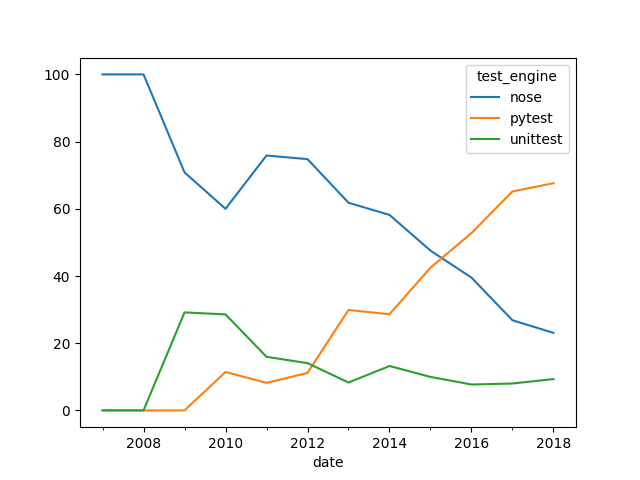

In [17]:
tests = (raw_data.groupby('test_engine')
         .resample('Y')['test_engine']
         .size()
         .unstack()
         .T
         .fillna(0)
         .apply(lambda line: 100 * line / float(line.sum()), axis=1)
         .plot())

# Tests

Sorry nose.

# Documentation directory

<IPython.core.display.Javascript object>


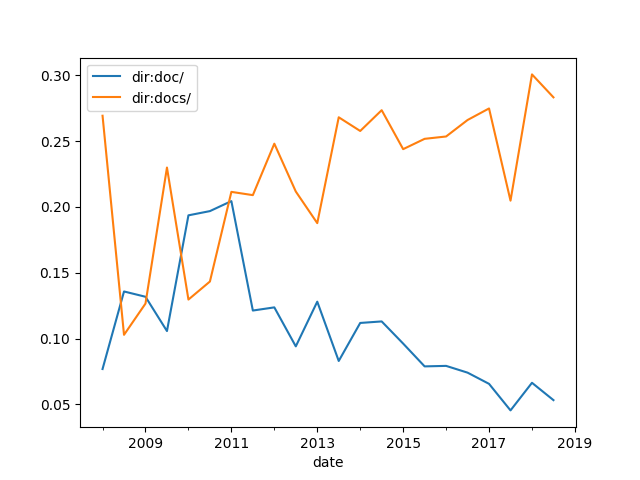

In [18]:
docs = stats['dir:doc/', 'dir:docs/'].mean().plot()

# Documentation directory

Concensus emmerged around 2011 towards `docs/` instead of `doc/`, let's stick to it (please, please, no `Docs`, I see you, cpython).

# src/ or not src/

<IPython.core.display.Javascript object>


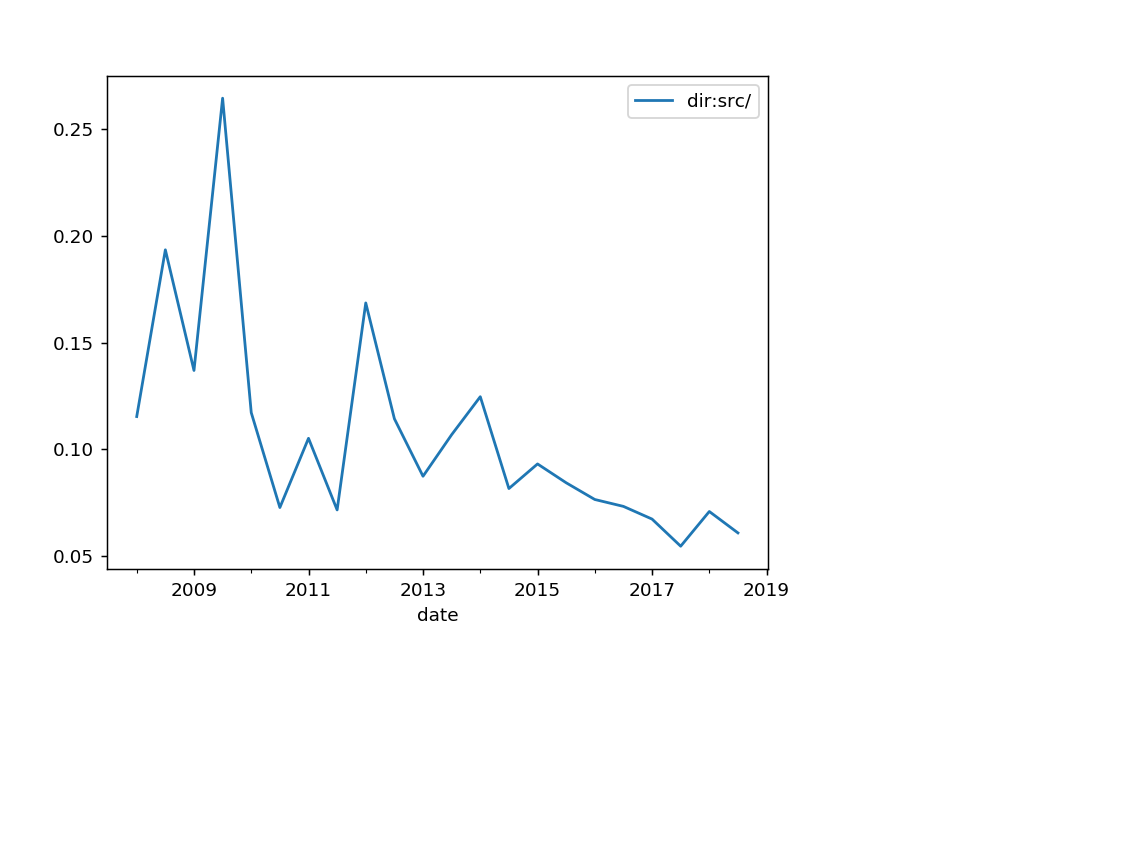

In [6]:
src = pd.DataFrame(stats['dir:src/'].mean()).plot()

# src/ or not src/

This one was slow, but the concensus is to drop the use of a `src/` directory.

I used it a lot, convinced it would allow me to spot earlier an import bug ("." being in PYTHONPATH but not "src/"). But that's way overkill for a small win.

# tests/ or test/?

<IPython.core.display.Javascript object>


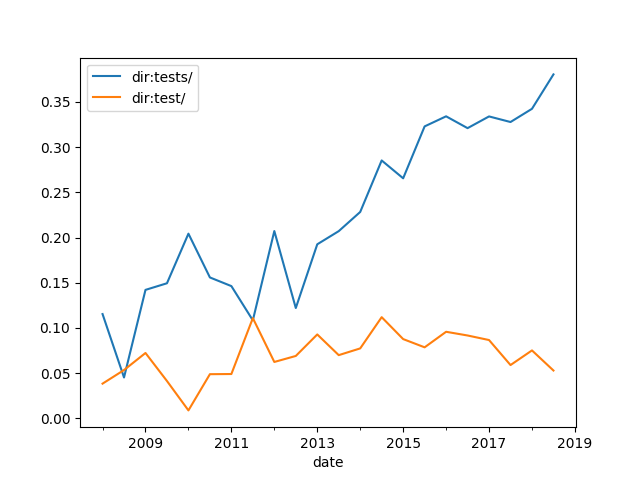

In [29]:
has_tests = stats['dir:tests/', 'dir:test/', ].mean().plot() 

# tests/ or test/?

I'm glad the concensus is as for `docs/` and `doc/`, plural clearly wins. I bet it's semantically better, as the folder does not contain a test, but multiple tests.

# Shebangs

In [30]:
shebangs = raw_data.loc['2008-01-01':,raw_data.columns.map(lambda col: col.startswith('shebang:'))].sum()

In [31]:
top_shebangs = shebangs.sort_values().tail(4).index

<IPython.core.display.Javascript object>


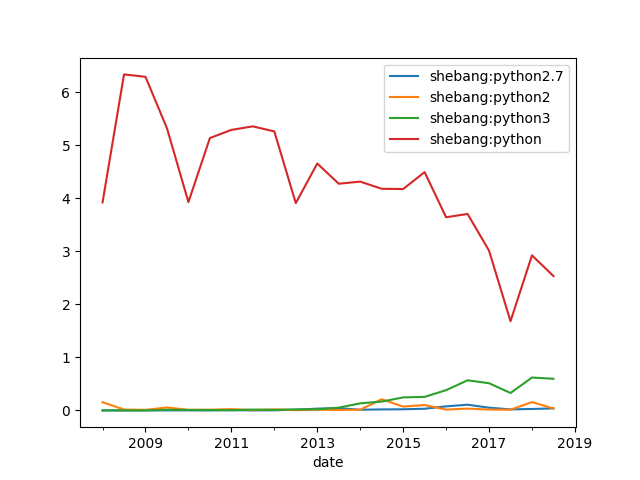

In [32]:
shebangs_plot = raw_data.loc['2008-01-01':, top_shebangs].fillna(value=0).resample('6M').mean().plot()

# Shebangs

I'm glad there's not so much `#!/usr/bin/env python2.7` here. Python 3 is slowly winning even if I'm not sure it's a good idea to give a version in the shebang.

<IPython.core.display.Javascript object>


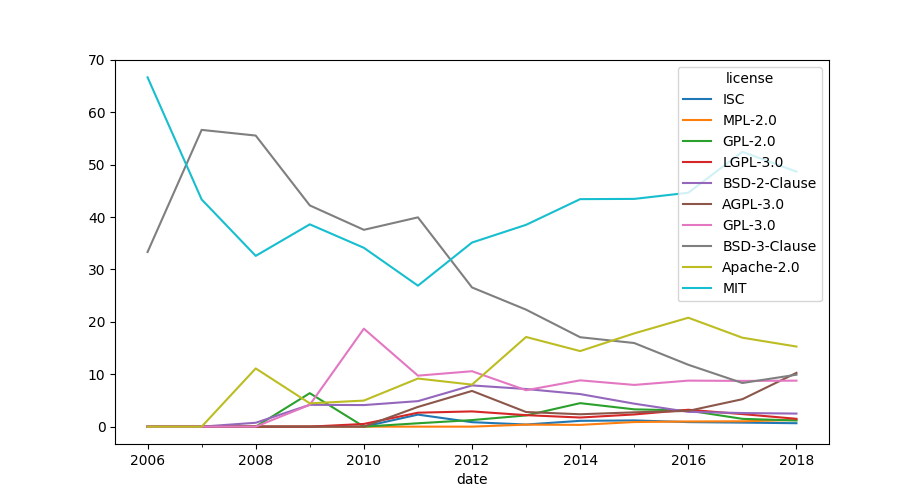

In [34]:
top_licenses = raw_data.groupby('license').size().sort_values().tail(10)
licenses = (raw_data.groupby('license')
            .resample('Y')['license']
            .size()
            .unstack()
            .T
            .fillna(0)
            .loc[:, list(top_licenses.index)]
            .apply(lambda line: 100 * line / float(line.sum()), axis=1)
            .plot())

<IPython.core.display.Javascript object>


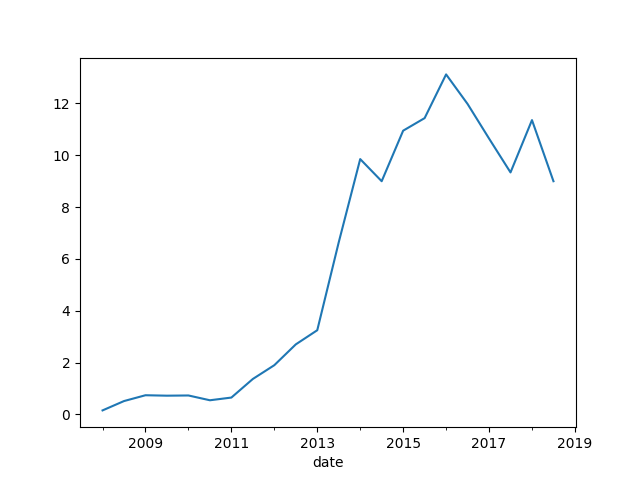

In [35]:
dunder_future = stats['dunder_future_pct'].mean().plot()

<IPython.core.display.Javascript object>


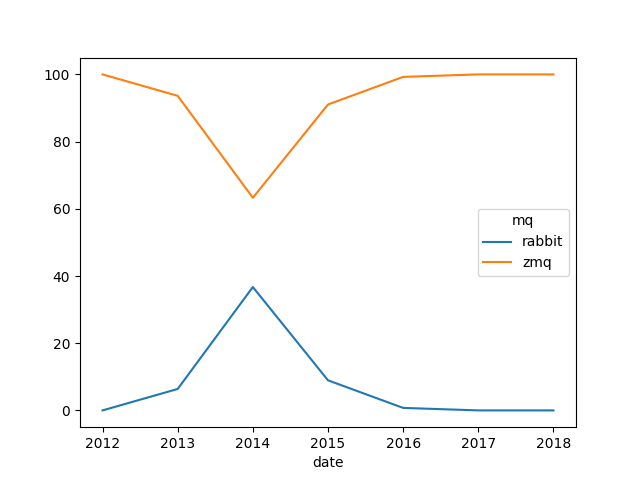

In [36]:
def get_mq(requirements):
    mqs = {'rabbit', 'zmq', 'activemq'}
    for mq in mqs:
        if mq in requirements:
            return mq
raw_data['mq'] = raw_data['requirements'].map(get_mq)
licenses = (raw_data.groupby('mq')
            .resample('Y')['mq']
            .size()
            .unstack()
            .T
            .fillna(0)
            .apply(lambda line: 100 * line / float(line.sum()), axis=1)
            .plot())